In [21]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import markers
import seaborn as sns

<h1>Load the data</h1>

In [28]:
columns = ['Education', 'Experience']
rows = ['Candidate_1', 'Candidate_2', 'Candidate_3']
values = np.array([[5,3], 
                   [4,5], 
                   [2,2]])

criterion_weights = pd.Series(data=np.array([0.25, 0.75]), index=columns)
data = pd.DataFrame(data=values, index=rows, columns=columns)
data

,Education,Experience
Candidate_1,5,3
Candidate_2,4,5
Candidate_3,2,2


<h1>Graphical methods</h1>

In [33]:
def weights_distributive(data, weights):
    
    r = data.sum(axis=0)
    alternative_weights = (data / np.repeat(r.values, 4, axis=0).reshape(4, 3)) * weights
    alternative_weights = alternative_weights.sum(axis=1)

    return alternative_weights

def get_diapasons(weights, global_weights, name, closest):
    
    closest_ = closest.copy()
    weight = weights[name]
    
    closest_['global_left'] = closest_['first'].apply(lambda x: global_weights[x]) 
    closest_['global_right'] = closest_['second'].apply(lambda x: global_weights[x]) 
    
    closest_column = closest_.groupby(by=['first']).apply(lambda x: pd.concat([x] \
                * len(closest_['first'].unique()))).reset_index(drop=True).drop(columns\
                                                                =['second'])[['first', 'x', 'global_left']]
    closest_columns = closest_column.reset_index(drop=True)

    truncated = pd.concat([closest_[['first', 'x', 'global_left']]] * 
                          len(closest_['first'].unique())).reset_index(drop=True)
    
    closest_ = pd.concat((truncated, closest_column[['first', 'x', 'global_left']]), axis=1)
    closest_.columns = ['first', 'x', 'global_left', 'second', 'y', 'global_right']
    closest_ = closest_[['first', 'second', 'x', 'y', 'global_left', 'global_right']]
    closest_ = closest_[closest_['x'] != closest_['y']]

    deltas_threshold = (closest_['global_left'] - closest_['global_right']) / \
    (closest_['x'] - closest_['y']) * 1. / weight
    deltas_threshold = pd.merge(deltas_threshold.to_frame(), closest_[['first', 'second']], 
                                left_index=True, right_index=True)
    
    return deltas_threshold
    #w_star = 

def gradient_method(data, weights, global_weights):
    
    criterion_names = data.columns
    size = int(len(criterion_names) // 2) + 1
    fig, axes = plt.subplots(size, size, figsize=(12, 8))
    
    for i, criterion_name in enumerate(criterion_names):
    
        weights_left = weights.copy()
        weights_right = weights.copy()

        weights_left[criterion_name] = 0
        weights_left /= weights_left.sum()

        weights_right[~weights.index.isin({criterion_name})] = 0
        weights_right /= weights_right.sum()

        weights_alternative_left = weights_distributive(data, weights_left)
        weights_alternative_right = weights_distributive(data, weights_right)
        weights_to_plot = pd.concat((weights_alternative_left, weights_alternative_right), axis=1)

        intersections = [np.linalg.solve(np.array([[(first[2] - first[1]), -1], [(second[2] - second[1]), -1]])
                                                   , -np.array([first[1], second[1]])) \
        for first in weights_to_plot.itertuples() for second in weights_to_plot.itertuples() if first != second]
        
        intersections_all = pd.DataFrame.from_records(((weights_to_plot.index[int(i // 4)], 
                                    weights_to_plot.index[i % 4], intersections[i][0], intersections[i][1]) \
                                                       for i in range(len(intersections))))
        intersections_all = intersections_all.set_index(intersections_all[0], drop=True)
        intersections_all = pd.DataFrame(intersections_all.values)
        #intersections_all = intersections_all.drop(columns=[0])
        intersections_all.columns = ['first', 'second', 'x', 'y']
        weights_to_plot['intersection'] = np.array([ (line[2] - line[1]) * weights[criterion_name] + line[1] \
                                                    for line in weights_to_plot.itertuples()])
        optimal_alternative = weights_to_plot['intersection'].index[weights_to_plot['intersection'].argmax()]

        dist = abs(intersections_all['x'] - weights[criterion_name])
        arg_point = np.argmin(dist)
        
        #print(intersections_all[intersections_all['first'] == optimal_alternative])
        dist_optimals = abs(intersections_all[intersections_all['first'] == optimal_alternative]['x'] 
                                                                            - weights[criterion_name])
        arg_opt = dist_optimals[dist_optimals == dist_optimals.min()].index[0]
        
        val_1 = dist.min() / weights[criterion_name]
        val_2 = dist_optimals.min() / weights[criterion_name]
        
        print("-------------------------")
        print(f"Ступінь чутливості попарного ранжування для {criterion_name}: {val_1}")
        print(f"Ступінь чутливості оптимального ранжування для {criterion_name}: {val_2}")
       
        closest = intersections_all.groupby(by=['first'])
        groups = []
        for group in closest:
        
            points = group[1][group[1]['first'] == group[0]][['second', 'x']]
            points['first'] = group[0]
            points['x'] -= weights[criterion_name]
            to_append = points[['first', 'second', 'x']][abs(points['x']) == abs(points['x']).min()].iloc[0] 
            to_append['x'] += weights[criterion_name]
            groups.append(to_append)
        
        closest = pd.concat(groups, axis=1).T
    
        deltas_threshold = get_diapasons(weights, global_weights, criterion_name, closest)
    
        ax = axes[int(i // 2), i % 2]
        ax.plot(weights_to_plot.values[:, :-1].T, linestyle='dashed')
        ax.scatter(intersections_all['x'], intersections_all['y'], color='red', s=10)
        ax.scatter(intersections_all.iloc[arg_point, 2], intersections_all.iloc[arg_point, 3], color='black', s=100)
        ax.scatter(intersections_all.iloc[arg_opt, 2], intersections_all.iloc[arg_opt, 3], color='green', s=100)
        ax.vlines(weights[criterion_name], 0, 0.4, colors='red')
        ax.legend(data.index, loc=4)
        fig.suptitle("Gradient method")
        ax.set_xlabel(criterion_name)
        ax.set_xlim(0, 1)
        
        print(deltas_threshold)
    

In [32]:
global_weights = weights_distributive(data, criterion_weights)
gradient_method(data, criterion_weights, global_weights)

ValueError: cannot reshape array of size 8 into shape (3,2)

In [25]:
data

,Education,Experience
Candidate_1,5,3
Candidate_2,4,5
Candidate_3,2,2


ValueError: cannot reshape array of size 8 into shape (4,3)

In [7]:
!pip install -q pulp

<h1>Fuzzy programming</h1>

In [8]:
from pulp import LpMaximize, LpVariable, LpProblem, lpSum, LpStatus
from scipy.stats import gmean

In [9]:
values = np.array([
    [np.array([1]), np.array([0.5, 4]), np.array([3, 6]), np.array([2, 5]), np.array([3, 9])],
    [np.array([0.25, 4]), np.array([1]), np.array([1, 5]), np.array([1, 5]), np.array([2, 6])],
    [np.array([1. / 6, 1. / 3]), np.array([0.2, 1]), np.array([1]), np.array([0.5, 4]), np.array([0.5, 5])],
    [np.array([0.2, 0.5]), np.array([0.2, 1]), np.array([0.25, 2]), np.array([1]), np.array([0.5, 7])],
    [np.array([1. / 9, 1. / 3]), np.array([1. / 6, 0.5]), np.array([0.2, 2]), np.array([1. / 7, 2]), np.array([1])]
])

data_fuzzy = pd.DataFrame(values)
ds = pd.DataFrame(np.ones(values.shape) * 0.5)

C:\Users\User\anaconda3\envs\iasa\lib\site-packages\ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [10]:
def build_hist(weights, weights_fuzzy):
    
    weights_ = weights.reset_index()
    weights_['kind'] = 'not fuzzy'
 
    weights_fuzzy_ = weights_fuzzy.reset_index()
    weights_fuzzy_['kind'] = 'fuzzy'

    weights_to_plot = pd.concat((weights_, weights_fuzzy_), axis=0)
    
    sns.barplot(data=weights_to_plot, y='weights', x='index', hue='kind')

def defuzzify(data_fuzzy):
    
    data = data_fuzzy.applymap(lambda x: gmean(x))
    return data

def GMM(data):
    
    n = data.shape[0]
    weights = np.exp(np.log(data.values).sum(axis=1) / n) / n
    weights = pd.DataFrame(weights, index=data.index, columns=['weights'])
    GCI = np.mean([np.log(data.iloc[i, j] * weights.loc[j] / weights.loc[i]) ** 2 \
                   for i in range(n) for j in range(n) if j > i])
    print(f"GCI={GCI}")
    return weights

def rang(data_fuzzy, weights):
    
    n = data_fuzzy.shape[0]
    print(np.array([[ weights.iloc[i] / (weights.iloc[i] + weights.iloc[j])  for j in range(n)] 
                                      for i in range(n)]))
    ro_table = pd.DataFrame(np.array([[ weights.iloc[i] / (weights.iloc[i] + weights.iloc[j])  for j in range(n)] 
                                      for i in range(n)]))
    return ro_table
    #rang_table = data_fuzzy.applymap(lambda x: max(1 - max((x[1] - x[0]) / ()))

def FPP(data_fuzzy, ds, verbose=False):
    
    n = data_fuzzy.shape[1]
    
    model = LpProblem("FPP", sense=LpMaximize)
    
    lam = LpVariable('lambda', lowBound=0, upBound=1)
    w = [LpVariable(f'w_{i + 1}', lowBound=0, upBound=1) for i in range(0, len(ds))]
    
    [print(k, i, j) \
                for i in range(n) for j in range(n) for k in range(2) if i > j]
    
    print(len(w))
    print(n, ds.shape, data_fuzzy.shape)
    lr_ineq = [ds.iloc[i, j] * lam + w[i] - data_fuzzy.iloc[i, j][1] * w[j] <= ds.iloc[i, j] if k == 0 \
                   else ds.iloc[i, j] * lam - w[i] + data_fuzzy.iloc[i, j][0] * w[j] <= ds.iloc[i, j] \
                   for i in range(n) for j in range(n) for k in range(2) if i < j]
    
    if verbose:
        for ineq in lr_ineq:
            print(f"subjected to {ineq};")
        
    constraint_sum = lpSum(w) == 1
    obj_func = lam
    
    for constraint in lr_ineq:
        model += constraint
        
    model += constraint_sum
    model += obj_func
    
    status = model.solve()
    
    summed = 0
    
    if verbose:  
        print(LpStatus[status])
        for var in w:
            print(f"{var.name}: {var.value()};")
            summed += var.value()
        print(f"optimal value {lam.value()}")

    w_fuzzy = pd.DataFrame([weight.value() for weight in w], index=data_fuzzy.index, columns=['weights'])
    CI = lam.value()
    print(f"CI={CI}")
    
    return w_fuzzy    

In [11]:
data_fuzzy

,0,1,2,3,4
0,[1],"[0.5, 4.0]","[3, 6]","[2, 5]","[3, 9]"
1,"[0.25, 4.0]",[1],"[1, 5]","[1, 5]","[2, 6]"
2,"[0.16666666666666666, 0.3333333333333333]","[0.2, 1.0]",[1],"[0.5, 4.0]","[0.5, 5.0]"
3,"[0.2, 0.5]","[0.2, 1.0]","[0.25, 2.0]",[1],"[0.5, 7.0]"
4,"[0.1111111111111111, 0.3333333333333333]","[0.16666666666666666, 0.5]","[0.2, 2.0]","[0.14285714285714285, 2.0]",[1]


In [12]:
# values = np.array([
#     [np.array([1]), np.array([2, 3]), np.array([3, 5]), np.array([4, 7])],
#     [np.array([1. / 3, 1. / 2]), np.array([1]), np.array([1, 2]), np.array([3, 4])],
#     [np.array([1. / 5, 1. / 3]), np.array([1. / 2, 1]), np.array([1]), np.array([2, 4])],
#     [np.array([1. / 7, 1. / 4]), np.array([1. / 4, 1. / 3]), np.array([1. / 4, 1. / 2]), np.array([1])]
# ])

# data_fuzzy_test = pd.DataFrame(values)
# ds = pd.DataFrame(np.ones(values.shape) * 0.5)

# data_fuzzy_test

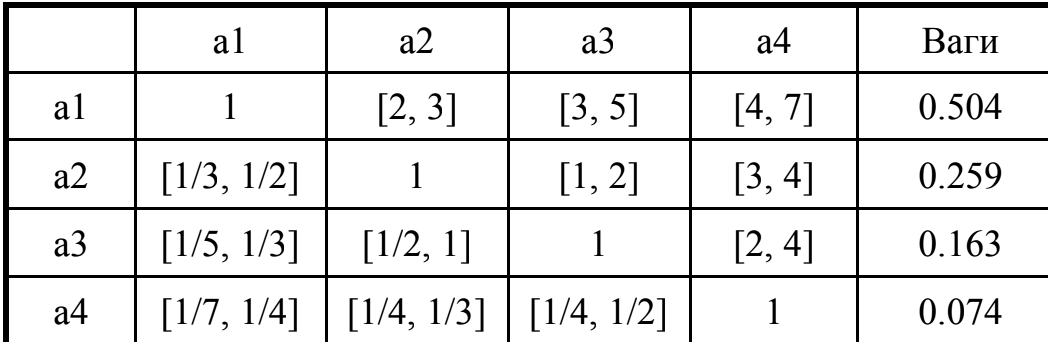

In [13]:
weights_fuzzy = FPP(data_fuzzy, ds, True)

0 1 0
1 1 0
0 2 0
1 2 0
0 2 1
1 2 1
0 3 0
1 3 0
0 3 1
1 3 1
0 3 2
1 3 2
0 4 0
1 4 0
0 4 1
1 4 1
0 4 2
1 4 2
0 4 3
1 4 3
5
5 (5, 5) (5, 5)
subjected to 0.5*lambda + w_1 - 4.0*w_2 <= 0.5;
subjected to 0.5*lambda - w_1 + 0.5*w_2 <= 0.5;
subjected to 0.5*lambda + w_1 - 6*w_3 <= 0.5;
subjected to 0.5*lambda - w_1 + 3*w_3 <= 0.5;
subjected to 0.5*lambda + w_1 - 5*w_4 <= 0.5;
subjected to 0.5*lambda - w_1 + 2*w_4 <= 0.5;
subjected to 0.5*lambda + w_1 - 9*w_5 <= 0.5;
subjected to 0.5*lambda - w_1 + 3*w_5 <= 0.5;
subjected to 0.5*lambda + w_2 - 5*w_3 <= 0.5;
subjected to 0.5*lambda - w_2 + w_3 <= 0.5;
subjected to 0.5*lambda + w_2 - 5*w_4 <= 0.5;
subjected to 0.5*lambda - w_2 + w_4 <= 0.5;
subjected to 0.5*lambda + w_2 - 6*w_5 <= 0.5;
subjected to 0.5*lambda - w_2 + 2*w_5 <= 0.5;
subjected to 0.5*lambda + w_3 - 4.0*w_4 <= 0.5;
subjected to 0.5*lambda - w_3 + 0.5*w_4 <= 0.5;
subjected to 0.5*lambda + w_3 - 5.0*w_5 <= 0.5;
subjected to 0.5*lambda - w_3 + 0.5*w_5 <= 0.5;
subjected to 0.5*lambda + 

In [14]:
data = defuzzify(data_fuzzy)
weights = GMM(data)

GCI=0.021986976716159512


In [15]:
pd.concat((weights, weights_fuzzy), axis=1)

,weights,weights
0,0.500953,0.578778
1,0.353787,0.144695
2,0.149797,0.096463
3,0.143033,0.115756
4,0.090318,0.064309


In [16]:
data

,0,1,2,3,4
0,1.000000,1.414214,4.242641,3.162278,5.196152
1,1.000000,1.000000,2.236068,2.236068,3.464102
2,0.235702,0.447214,1.000000,1.414214,1.581139
3,0.316228,0.447214,0.707107,1.000000,1.870829
4,0.192450,0.288675,0.632456,0.534522,1.000000


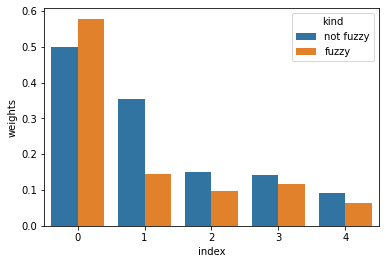

In [17]:
build_hist(weights, weights_fuzzy)